In [497]:
# import libraries
import pandas as pd
import networkx as nx
from pyvis.network import Network
import numpy as np
import matplotlib.pyplot as plt

# Load Data and Create Network

In [498]:
# now let's iterate through our amicus briefs and store the lexisCite, position, and amicus name
# data from https://amicispace.ucmerced.edu/data
amicus_briefs_csv = pd.read_csv("amicus_briefs.csv", encoding="latin")
amicus_briefs_csv = amicus_briefs_csv[["LexisCite", "Position", "AmicusName"]]
amicus_briefs_csv.head(5)

,LexisCite,Position,AmicusName
0,1953 U.S. LEXIS 2673,1,SECURITIES AND EXCHANGE COMMISSION
1,1953 U.S. LEXIS 2680,2,BOSTON AMERICAN LEAGUE BASE BALL COMPANY
2,1954 U.S. LEXIS 2094,1,AMERICAN FEDERATION OF TEACHERS
3,1954 U.S. LEXIS 2094,1,UNITED STATES
4,1954 U.S. LEXIS 2094,1,AMERICAN JEWISH CONGRESS


<Axes: >

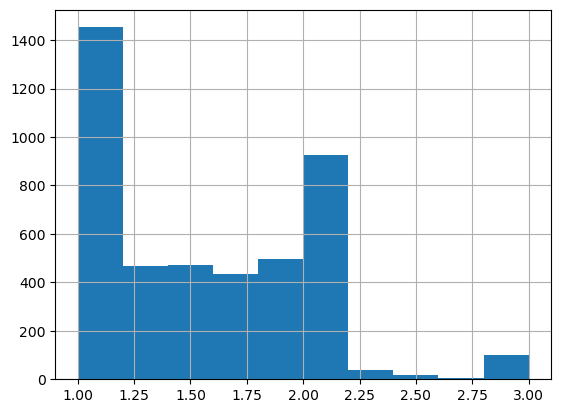

In [499]:
amicus_briefs_csv.groupby('LexisCite')['Position'].mean().hist()

In [500]:
# some perfect duplicates -- drop?
amicus_briefs_csv.duplicated().mean()

0.007130397137654863

In [501]:
# drop perfect duplicates
amicus_briefs_csv = amicus_briefs_csv.drop_duplicates()

In [502]:
# position variable in amicus briefs
# = 1 if the brief argues the lower court decision should be reversed
# = 2 if lower court decision should be affirmed
# = 3 if the brief explicitly does not adopt a position or the position is unclear
amicus_briefs_csv["Position"].value_counts().sort_index()

Position
1    36942
2    38977
3     2058
Name: count, dtype: int64

In [503]:
amicus_briefs_csv["Position"].isna().mean()  # no missing values!

0.0

In [504]:
# let's now get the justices and their votes for each case (identified by LexisCite and caseName)
# data from http://scdb.wustl.edu/documentation.php
justices_csv = pd.read_csv("justices.csv", encoding="latin")
justices_csv.columns

C:\Users\Jennah\AppData\Local\Temp\ipykernel_40928\56783121.py:3: DtypeWarning: Columns (6,16) have mixed types. Specify dtype option on import or set low_memory=False.
  justices_csv = pd.read_csv("justices.csv", encoding="latin")


Index(['caseId', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision',
       'decisionType', 'usCite', 'sctCite', 'ledCite', 'lexisCite', 'term',
       'naturalCourt', 'chief', 'docket', 'caseName', 'dateArgument',
       'dateRearg', 'petitioner', 'petitionerState', 'respondent',
       'respondentState', 'jurisdiction', 'adminAction', 'adminActionState',
       'threeJudgeFdc', 'caseOrigin', 'caseOriginState', 'caseSource',
       'caseSourceState', 'lcDisagreement', 'certReason', 'lcDisposition',
       'lcDispositionDirection', 'declarationUncon', 'caseDisposition',
       'caseDispositionUnusual', 'partyWinning', 'precedentAlteration',
       'voteUnclear', 'issue', 'issueArea', 'decisionDirection',
       'decisionDirectionDissent', 'authorityDecision1', 'authorityDecision2',
       'lawType', 'lawSupp', 'lawMinor', 'majOpinWriter', 'majOpinAssigner',
       'splitVote', 'majVotes', 'minVotes', 'justice', 'justiceName', 'vote',
       'opinion', 'direction', 'majority', 'firstA

In [505]:
[x for x in justices_csv.columns if 'direction' in x.lower()]

['lcDispositionDirection',
 'decisionDirection',
 'decisionDirectionDissent',
 'direction']

In [506]:
justices_csv = justices_csv[
    [
        "lexisCite",
        "justiceName",
        "vote",
        "caseName",
        "caseDisposition",
        "lcDispositionDirection",
        "decisionDirection",
        "direction",
    ]
]
justices_csv.head(5)

,lexisCite,justiceName,vote,caseName,caseDisposition,lcDispositionDirection,decisionDirection,direction
0,1946 U.S. LEXIS 1724,HHBurton,2.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,2.0,1.0
1,1946 U.S. LEXIS 1724,RHJackson,1.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,2.0,2.0
2,1946 U.S. LEXIS 1724,WODouglas,1.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,2.0,2.0
3,1946 U.S. LEXIS 1724,FFrankfurter,4.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,2.0,2.0
4,1946 U.S. LEXIS 1724,SFReed,1.0,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,3.0,1.0,2.0,2.0


In [507]:
# drop perfect duplicates
justices_csv = justices_csv.drop_duplicates()

In [508]:
# note the values of votes:
# Values:
# 1	voted with majority or plurality
# 2	dissent
# 3	regular concurrence
# 4	special concurrence
# 5	judgment of the Court
# 6	dissent from a denial or dismissal of certiorari , or dissent from summary affirmation of an appeal
# 7	jurisdictional dissent
# 8	justice participated in an equally divided vote
justices_csv["vote"].value_counts().sort_index()

vote
1.0    57671
2.0    14056
3.0     3039
4.0     3627
5.0      256
6.0       20
7.0      390
8.0      924
Name: count, dtype: int64

In [509]:
justices_csv["caseName"].unique().shape[0]

8907

In [510]:
justices_csv[
    "vote"
].isna().mean()  # votes are missing in about 2% of cases -- should we drop these?

0.024680819930005975

In [511]:
# direction is the "Direction of the Individual Justice's Votes"
# 1 = conservative
# 2 = liberal
justices_csv["direction"].value_counts().sort_index()

direction
1.0    36635
2.0    40699
Name: count, dtype: int64

In [512]:
# This variable specifies whether the decision of the court whose decision the Supreme Court reviewed was itself liberal or conservative as these terms are defined in the direction of decision variable (decisionDirection).
# 1	conservative
# 2	liberal
# 3	unspecifiable
justices_csv["lcDispositionDirection"].value_counts().sort_index()

lcDispositionDirection
1.0    44459
2.0    34773
3.0      872
Name: count, dtype: int64

In [513]:
# In order to determine whether the Court supports or opposes the issue to which the case pertains, this variable codes the ideological "direction" of the decision.
# 1	conservative
# 2	liberal
# 3	unspecifiable
justices_csv["decisionDirection"].value_counts().sort_index()

decisionDirection
1.0    39242
2.0    40970
3.0     1427
Name: count, dtype: int64

In [514]:
# check that decision direction doesn't vary by case
justices_csv.groupby('lexisCite')['decisionDirection'].nunique().unique()

array([1, 0], dtype=int64)

In [515]:
# cases with 0 unique values are missing -- should we drop these?
justices_csv.loc[justices_csv['lexisCite']=='1955 U.S. LEXIS 945']

,lexisCite,justiceName,vote,caseName,caseDisposition,lcDispositionDirection,decisionDirection,direction
8911,1955 U.S. LEXIS 945,EWarren,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8912,1955 U.S. LEXIS 945,HLBlack,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8913,1955 U.S. LEXIS 945,SFReed,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8914,1955 U.S. LEXIS 945,FFrankfurter,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8915,1955 U.S. LEXIS 945,WODouglas,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8916,1955 U.S. LEXIS 945,HHBurton,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8917,1955 U.S. LEXIS 945,TCClark,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8918,1955 U.S. LEXIS 945,SMinton,8.0,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN
8919,1955 U.S. LEXIS 945,JHarlan2,NaN,"RYAN STEVEDORING CO., INC. v. PANATLANTIC STEA...",2.0,NaN,NaN,NaN


In [516]:
#  A missing value code indicates that the decisionDirection was unspecifiable or that that justice did not participate.
justices_csv[
    "direction"
].isna().mean()  # direction is missing in about 5% of justice/case combinations

0.05698294048069067

In [517]:
justices_csv[["justiceName", "lexisCite"]].value_counts()  # why are there duplicates?

justiceName  lexisCite           
WODouglas    1974 U.S. LEXIS 102     2
SFReed       1955 U.S. LEXIS 1542    1
             1955 U.S. LEXIS 602     1
             1955 U.S. LEXIS 601     1
             1955 U.S. LEXIS 37      1
                                    ..
HHBurton     1948 U.S. LEXIS 2110    1
             1948 U.S. LEXIS 2086    1
             1948 U.S. LEXIS 2085    1
             1948 U.S. LEXIS 2084    1
WODouglas    1975 U.S. LEXIS 93      1
Name: count, Length: 82006, dtype: int64

In [518]:
# drop case with contradictory votes or check online to corroborate?
justices_csv[
    justices_csv[["justiceName", "lexisCite"]].duplicated(keep=False)
].sort_values(["lexisCite", "justiceName"])

,lexisCite,justiceName,vote,caseName,caseDisposition,lcDispositionDirection,decisionDirection,direction
33240,1974 U.S. LEXIS 102,WODouglas,2.0,MISSISSIPPI v. ARKANSAS,NaN,NaN,3.0,NaN
33249,1974 U.S. LEXIS 102,WODouglas,1.0,MISSISSIPPI v. ARKANSAS,NaN,NaN,3.0,NaN


In [519]:
# for final case decision:
# 1	stay, petition, or motion granted
# 2	affirmed (includes modified)
# 3	reversed
# 4	reversed and remanded
# 5	vacated and remanded
# 6	affirmed and reversed (or vacated) in part
# 7	affirmed and reversed (or vacated) in part and remanded
# 8	vacated
# 9	petition denied or appeal dismissed
# 10	certification to or from a lower court
# 11	no disposition

# do we want to drop any of these where the case disposition seems like it would be tricky...
# or does it matter less because we care mostly about judge voting behavior?
justices_csv["caseDisposition"].value_counts().sort_index()

caseDisposition
1.0       421
2.0     24302
3.0     17954
4.0     22277
5.0     10045
6.0       683
7.0      1508
8.0       303
9.0      3204
10.0      116
11.0        9
Name: count, dtype: int64

In [520]:
justices_csv["caseDisposition"].isna().mean()  # around 1% are missing case disposition

0.014449985976806858

In [521]:
justices_csv["decisionDirection"].isna().mean()  # < 1% are missing decision direction

0.004487421805455632

## Create Dictionary for Generating Network

In [522]:
# for simplicity, we want the final form factor to be a dictionary as it's easier to parse and find information
# let's first convert the amicus briefs into a dictionary with one key per docket
# each docket will have all the amicus briefs with the organization names and their positions

amici_data = {}

for _, brief_row in amicus_briefs_csv.iterrows():
    lexis_cite = brief_row["LexisCite"]
    amicus_name = brief_row["AmicusName"]
    position = brief_row["Position"]

    if lexis_cite not in amici_data:
        amici_data[lexis_cite] = []

    amici_data[lexis_cite].append((amicus_name, position))

list(amici_data.items())[:3]

[('1953 U.S. LEXIS 2673', [('SECURITIES AND EXCHANGE COMMISSION', 1)]),
 ('1953 U.S. LEXIS 2680', [('BOSTON AMERICAN LEAGUE BASE BALL COMPANY', 2)]),
 ('1954 U.S. LEXIS 2094',
  [('AMERICAN FEDERATION OF TEACHERS', 1),
   ('UNITED STATES', 1),
   ('AMERICAN JEWISH CONGRESS', 1),
   ('AMERICAN VETERANS COMMITTEE', 1),
   ('AMERICAN ETHICAL UNION', 1),
   ('AMERICAN JEWISH COMMITTEE', 1),
   ('ANTI-DEFAMATION LEAGUE', 1),
   ('JAPANESE AMERICAN CITIZENS LEAGUE', 1),
   ('UNITARIAN FELLOWSHIP FOR SOCIAL JUSTICE', 1),
   ('AMERICAN CIVIL LIBERTIES UNION', 1),
   ('CONGRESS OF INDUSTRIAL ORGANIZATIONS', 1)])]

In [523]:
# let's also do this for the judges
justices_data = {}

for _, justice_row in justices_csv.iterrows():
    lexis_cite = justice_row["lexisCite"]
    justice_name = justice_row["justiceName"]
    case_name = justice_row["caseName"]
    vote = justice_row["vote"]
    disposition = justice_row["caseDisposition"]
    decisiondirection = justice_row["decisionDirection"]
    direction = justice_row["direction"]

    if lexis_cite not in justices_data:
        justices_data[lexis_cite] = {
            "justices": [],
            "caseName": case_name,
            "decision": disposition,
            "decisiondirection": decisiondirection,
        }

    justices_data[lexis_cite]["justices"].append((justice_name, vote, direction))

list(justices_data.items())[:2]

[('1946 U.S. LEXIS 1724',
  {'justices': [('HHBurton', 2.0, 1.0),
    ('RHJackson', 1.0, 2.0),
    ('WODouglas', 1.0, 2.0),
    ('FFrankfurter', 4.0, 2.0),
    ('SFReed', 1.0, 2.0),
    ('HLBlack', 1.0, 2.0),
    ('WBRutledge', 1.0, 2.0),
    ('FMurphy', 1.0, 2.0),
    ('FMVinson', 1.0, 2.0)],
   'caseName': 'HALLIBURTON OIL WELL CEMENTING CO. v. WALKER et al., DOING BUSINESS AS DEPTHOGRAPH CO.',
   'decision': 3.0,
   'decisiondirection': 2.0}),
 ('1946 U.S. LEXIS 1725',
  {'justices': [('HHBurton', 1.0, 1.0),
    ('RHJackson', 2.0, 2.0),
    ('WODouglas', 1.0, 1.0),
    ('FFrankfurter', 1.0, 1.0),
    ('SFReed', 1.0, 1.0),
    ('HLBlack', 2.0, 2.0),
    ('WBRutledge', 4.0, 1.0),
    ('FMurphy', 2.0, 2.0),
    ('FMVinson', 1.0, 1.0)],
   'caseName': 'CLEVELAND v. UNITED STATES',
   'decision': 2.0,
   'decisiondirection': 1.0})]

In [524]:
# make a function for determining ideological position of amicus

# position variable in amicus briefs
# = 1 if the brief argues the lower court decision should be reversed
# = 2 if lower court decision should be affirmed
# = 3 if the brief explicitly does not adopt a position or the position is unclear

# case decision values
# 1	stay, petition, or motion granted
# 2	affirmed (includes modified)
# 3	reversed
# 4	reversed and remanded
# 5	vacated and remanded
# 6	affirmed and reversed (or vacated) in part
# 7	affirmed and reversed (or vacated) in part and remanded
# 8	vacated
# 9	petition denied or appeal dismissed
# 10 certification to or from a lower court
# 11 no disposition

# case direction values

def amicusDirection(brief_position, case_decision, case_direction):
    """
    Determines the direction of the amicus based on agreement between judge decision and amicus.
    """
    # if we have any invalid values, let's remove this scenario
    try:
        position, decision, direction = (
            int(brief_position),
            int(case_decision),
            int(case_direction),
        )
    except:
        return 99

    # also invalid if direction is unspecifiable
    if direction == 3:
        return 99

    # case where brief argues the lower court decision should be reversed
    # and decision is (3) reversed, (4) reversed and remanded
    # also including:
        # (5) vacated and remanded
        # (8) vacated
        # (9) petition denied or appeal dismissed
    
    # direction of amicus brief should match case direction
    if position == 1 and (decision in [3, 4, 5, 8, 9]):
        return direction
    # argue lower court decision should be affirmed
    # and decision is (2) affirmed (includes modified)
    # -- note: should this also include (1)?
    # (1) stay, petition, or motion granted
    elif position == 2 and (decision in [1, 2]):
        return direction
    # if the position is to reverse
    # and decision is (2) affirmed (includes modified)
    elif position == 1 and (decision in [1, 2]):
        return 1 if direction == 2 else 2
    # if the position is to reverse
    # and decision is (2) affirmed (includes modified)
    elif position == 2 and (decision in [3, 4, 5, 8, 9]):
        return 1 if direction == 2 else 2
    else:
        return 99

In [525]:
def isConservative(direction):
    """
    Identifies whether direction is conservative (i.e., = 1)
    """
    if direction == 99:
        return np.nan
    else:
        return direction == 1

In [526]:
# Now we can merge our dictionaries together to get a final pre-processed dictionary
preproc_data = {}

for lexis_cite, brief in amici_data.items():
    justices_found = justices_data[lexis_cite]

    # if we can't find the corresponding case, we'll skip this row
    if justices_found is None:
        continue

    # calculate the percent conservative
    amicus_conservative_list = [isConservative(amicusDirection(amicus[1], justices_found['decision'], justices_found['decisiondirection'])) \
                                 for amicus in brief]
    amicus_unique_positions = np.unique([amicus[1] for amicus in brief])
    assert len(amicus_conservative_list) == len(brief)

    preproc_data[lexis_cite] = {
        "case_name": justices_found["caseName"],
        "justices": justices_found["justices"],
        "case_decision": justices_found["decision"],
        "decisiondirection": justices_found["decisiondirection"],
        "amici": brief,
        "conservative_amici": amicus_conservative_list,
        "percent_conservative": np.mean(amicus_conservative_list),
        "distinct_amicus_positions": len(amicus_unique_positions)
    }

list(preproc_data.items())[:3]

[('1953 U.S. LEXIS 2673',
  {'case_name': 'WILKO v. SWAN et al., DOING BUSINESS AS HAYDEN, STONE & CO., et al.',
   'justices': [('HLBlack', 1.0, 2.0),
    ('WODouglas', 1.0, 2.0),
    ('EWarren', 1.0, 2.0),
    ('TCClark', 1.0, 2.0),
    ('FFrankfurter', 2.0, 1.0),
    ('HHBurton', 1.0, 2.0),
    ('SFReed', 1.0, 2.0),
    ('SMinton', 2.0, 1.0),
    ('RHJackson', 3.0, 2.0)],
   'case_decision': 3.0,
   'decisiondirection': 2.0,
   'amici': [('SECURITIES AND EXCHANGE COMMISSION', 1)],
   'conservative_amici': [False],
   'percent_conservative': 0.0,
   'distinct_amicus_positions': 1}),
 ('1953 U.S. LEXIS 2680',
  {'case_name': 'TOOLSON v. NEW YORK YANKEES, INC. et al.',
   'justices': [('HLBlack', 1.0, 1.0),
    ('WODouglas', 1.0, 1.0),
    ('EWarren', 1.0, 1.0),
    ('TCClark', 1.0, 1.0),
    ('FFrankfurter', 1.0, 1.0),
    ('HHBurton', 2.0, 2.0),
    ('SFReed', 2.0, 2.0),
    ('SMinton', 1.0, 1.0),
    ('RHJackson', 1.0, 1.0)],
   'case_decision': 2.0,
   'decisiondirection': 1.0,
   

In [527]:
# let's make a function to determine if the judges agreed with the amicus brief
# here we need to determine whether the judge followed the amicus decision

# for amicus brief position:
# Indicates the position on the case expressed by the amicus brief.
# = 1 if the brief argues the lower court decision should be reversed,
# = 2 if lower court decision should be affirmed,
# = 3 if the brief explicitly does not adopt a position or the position is unclear.

# for final case decision:
# 1	stay, petition, or motion granted
# 2	affirmed (includes modified)
# 3	reversed
# 4	reversed and remanded
# 5	vacated and remanded
# 6	affirmed and reversed (or vacated) in part
# 7	affirmed and reversed (or vacated) in part and remanded
# 8	vacated
# 9	petition denied or appeal dismissed
# 10 certification to or from a lower court
# 11 no disposition

# for justice vote:
# 1	voted with majority or plurality
# 2	dissent
# 3	regular concurrence
# 4	special concurrence
# 5	judgment of the Court
# 6	dissent from a denial or dismissal of certiorari , or dissent from summary affirmation of an appeal
# 7	jurisdictional dissent
# 8	justice participated in an equally divided vote


def judgeAgreesWithAmicus(brief_position, case_decision, justice_vote):
    # if we have any invalid values, let's remove this scenario
    try:
        position, decision, vote = (
            int(brief_position),
            int(case_decision),
            int(justice_vote),
        )
    except:
        return 2

    # agrees with amicus brief for reversing lower court decision
    if position == 1 and (decision == 3 or decision == 4) and vote == 1:
        return 1

    # disagrees with amicus brief for reversing lower court decision
    if position == 1 and (decision == 3 or decision == 4) and vote == 2:
        return 0

    # agrees with amicus brief for affirming lower court decision
    if position == 2 and (decision == 2) and vote == 1:
        return 1

    # disagrees with amicus brief for affirming lower court decision
    if position == 2 and (decision == 2) and vote == 2:
        return 0

    # invalid scenario
    return 2

In [528]:
# Let's construct a graph now
# We make an assumption that the judges and amicus organizations have no overlapping names

G = nx.MultiDiGraph()

# We also are going to keep track of the justices and amici that make the final graph
final_justices = set()
final_amici = set()
final_cases = set()
final_cases_per_justice = {}

for lexis_cite, docket in preproc_data.items():
    conservative_amicus_list = []
    for amicus in docket["amici"]:
        # identify the ideological direction of the amicus brief based on its relationship with the disposition
        # and the disposition direction
        amicus_direction = amicusDirection(
            amicus[1], docket["case_decision"], docket["decisiondirection"]
        )
        for justice in docket["justices"]:
            # identify whether the judge agrees with the amicus
            # 0 = disagree, 1 = agree, 2 = trash
            agreement = judgeAgreesWithAmicus(
                amicus[1], docket["case_decision"], justice[1]
            )
            # identify whether judge's opinion is conservative
            conservative_position = int(justice[2] == 1)
            ideological_agreement = int(justice[2] == amicus_direction)
            if agreement < 2:
                final_justices.add(justice[0])
                final_amici.add(amicus[0])
                final_cases.add(lexis_cite)

                if justice[0] not in final_cases_per_justice:
                    final_cases_per_justice[justice[0]] = set()
                final_cases_per_justice[justice[0]].add(lexis_cite)

                G.add_edge(
                    justice[0],
                    amicus[0],
                    caseName=docket["case_name"],
                    agreement=agreement,
                    ideological_agreement=ideological_agreement,
                    amicus_direction=amicus_direction,
                    judge_direction=justice[2],
                )

In [529]:
# Create a visualization of a mini-version of the graph

G_mini = nx.MultiDiGraph()

# going to use a counter so we can visualize faster
maxCount = 10  # Comment line out for full graph
counter = 0

for lexis_cite, docket in preproc_data.items():
    if counter >= maxCount:
        break
    for amicus in docket["amici"]:
        for justice in docket["justices"]:
            # 0 = disagree, 1 = agree, 2 = trash
            agreement = judgeAgreesWithAmicus(
                amicus[1], docket["case_decision"], justice[1]
            )
            if agreement < 2:
                G_mini.add_edge(
                    justice[0],
                    amicus[0],
                    caseName=docket["case_name"],
                    agreement=agreement,
                )
                counter += 1

net = Network(
    directed=True,
    select_menu=True,  # Show part 1 in the plot (optional)
    filter_menu=True,  # Show part 2 in the plot (optional)
)

net.show_buttons()  # Show part 3 in the plot (optional)
net.from_nx(G_mini)  # Create directly from nx graph
net.show("test.html")
print("open the test.html file created!!")

open the test.html file created!!


In [530]:
# Quick sanity check for the two graphs
agree = 0
disagree = 0
for edge in G.edges(data=True):
    if edge[2]["agreement"]:
        agree += 1
    else:
        disagree += 1

print("full graph")
print("agree:", agree, "\ndisagree:", disagree, "\ntotal:", agree + disagree)

agree = 0
disagree = 0
for edge in G_mini.edges(data=True):
    if edge[2]["agreement"]:
        agree += 1
    else:
        disagree += 1

print("\nmini graph")
print("agree:", agree, "\ndisagree:", disagree, "\ntotal:", agree + disagree)

full graph
agree: 193811 
disagree: 62305 
total: 256116

mini graph
agree: 13 
disagree: 4 
total: 17


In [531]:
# sanity check for our data

# number of judges
print("number of judges:", len(final_justices))

# number of amici organizations
print("number of amici:", len(final_amici))

# total number of amicus briefs
print("number of cases:", len(final_cases))

# number of cases per judge
cases_per_justice = {}

for justice in final_justices:
    cases_per_justice[justice] = len(final_cases_per_justice[justice])

# number of cases per amicus
cases_per_amicus = {}

for amicus in final_amici:
    cases_per_amicus[justice] = len(G.in_edges(amicus))

print("avg number of cases per judge:", np.mean(list(cases_per_justice.values())))
print("avg number of cases per amicus:", np.mean(list(cases_per_amicus.values())))

number of judges: 33
number of amici: 10426
number of cases: 2813
avg number of cases per judge: 664.1818181818181
avg number of cases per amicus: 63.0


## Plot distribution of filings across cases

In [532]:
# create dataframe for ease of data manipulation
df = pd.DataFrame.from_dict(preproc_data, orient="index")
df.head()

,case_name,justices,case_decision,decisiondirection,amici,conservative_amici,percent_conservative,distinct_amicus_positions
1953 U.S. LEXIS 2673,"WILKO v. SWAN et al., DOING BUSINESS AS HAYDEN...","[(HLBlack, 1.0, 2.0), (WODouglas, 1.0, 2.0), (...",3.0,2.0,"[(SECURITIES AND EXCHANGE COMMISSION, 1)]",[False],0.0,1
1953 U.S. LEXIS 2680,"TOOLSON v. NEW YORK YANKEES, INC. et al.","[(HLBlack, 1.0, 1.0), (WODouglas, 1.0, 1.0), (...",2.0,1.0,"[(BOSTON AMERICAN LEAGUE BASE BALL COMPANY, 2)]",[True],1.0,1
1954 U.S. LEXIS 2094,BROWN et al. v. BOARD OF EDUCATION OF TOPEKA e...,"[(HLBlack, 1.0, 2.0), (WODouglas, 1.0, 2.0), (...",1.0,2.0,"[(AMERICAN FEDERATION OF TEACHERS, 1), (UNITED...","[True, True, True, True, True, True, True, Tru...",1.0,1
1954 U.S. LEXIS 2095,BOLLING et al. v. SHARPE et al.,"[(HLBlack, 1.0, 2.0), (WODouglas, 1.0, 2.0), (...",1.0,2.0,"[(AMERICAN FEDERATION OF TEACHERS, 1), (UNITED...","[True, True, True, True, True, True, True, Tru...",1.0,1
1954 U.S. LEXIS 2336,BENTSEN et al. v. BLACKWELL et al.,"[(HLBlack, 1.0, 1.0), (WODouglas, 1.0, 1.0), (...",9.0,1.0,"[(SECURITIES AND EXCHANGE COMMISSION, 2)]",[False],0.0,1


In [533]:
df["num_amici"] = df["amici"].apply(lambda x: len(x))
df[["amici", "num_amici"]].head(5)

,amici,num_amici
1953 U.S. LEXIS 2673,"[(SECURITIES AND EXCHANGE COMMISSION, 1)]",1
1953 U.S. LEXIS 2680,"[(BOSTON AMERICAN LEAGUE BASE BALL COMPANY, 2)]",1
1954 U.S. LEXIS 2094,"[(AMERICAN FEDERATION OF TEACHERS, 1), (UNITED...",11
1954 U.S. LEXIS 2095,"[(AMERICAN FEDERATION OF TEACHERS, 1), (UNITED...",21
1954 U.S. LEXIS 2336,"[(SECURITIES AND EXCHANGE COMMISSION, 2)]",1


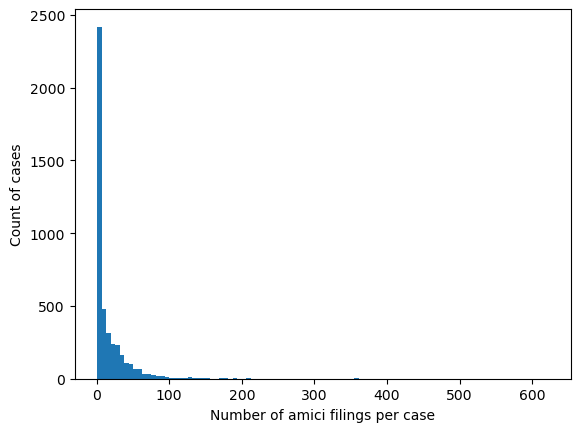

In [534]:
plt.hist(df["num_amici"], bins=100)
plt.ylabel("Count of cases")
plt.xlabel("Number of amici filings per case");

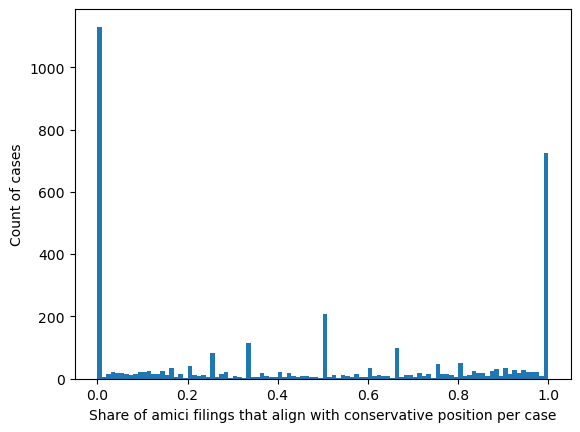

In [535]:
plt.hist(df["percent_conservative"], bins=100)
plt.ylabel("Count of cases")
plt.xlabel("Share of amici filings that align with conservative position per case");

In [536]:
(df["distinct_amicus_positions"] == 1).mean()
# in about 45% of cases all amici share the same position

0.4544424297370807

In [537]:
df['percent_conservative'].isna().mean()

0.16613780598368086

In [538]:
# cut down cases with 1
(df['num_amici']==1).mean()

0.20126926563916592

#

## Apply additional filters, check dist
* Drop cases with only 1 amicus
* Drop cases with any amicus that has a missing value for conservative
* Drop cases with unspecifiable decision direction

In [539]:
df.loc[df['percent_conservative'].isna()]

,case_name,justices,case_decision,decisiondirection,amici,conservative_amici,percent_conservative,distinct_amicus_positions,num_amici
1954 U.S. LEXIS 2621,FEDERAL POWER COMMISSION v. NIAGARA MOHAWK POW...,"[(HLBlack, 2.0, 2.0), (WODouglas, 2.0, 2.0), (...",2.0,1.0,"[(NEW YORK, 3)]",[nan],NaN,1,1
1954 U.S. LEXIS 2690,RADIO OFFICERS' UNION OF THE COMMERCIAL TELEGR...,"[(HLBlack, 2.0, 2.0), (WODouglas, 2.0, 2.0), (...",2.0,1.0,[(NEWSPAPER AND MAIL DELIVERERS UNION OF NEW Y...,[nan],NaN,1,1
1955 U.S. LEXIS 1186,TEE-HIT-TON INDIANS v. UNITED STATES,"[(HLBlack, 1.0, 2.0), (WODouglas, 2.0, 1.0), (...",2.0,2.0,"[(IDAHO, 3), (UTAH, 1), (NEW MEXICO, 3)]","[nan, True, nan]",NaN,2,3
1955 U.S. LEXIS 734,BROWN et al. v. BOARD OF EDUCATION OF TOPEKA e...,"[(JHarlan2, 1.0, 2.0), (HLBlack, 1.0, 2.0), (W...",4.0,2.0,"[(NORTH CAROLINA, 3), (UNITED STATES, 3), (MAR...","[nan, nan, nan, nan, nan, nan, nan, nan]",NaN,1,8
1956 U.S. LEXIS 1803,"DE SYLVA v. BALLENTINE, GUARDIAN","[(JHarlan2, 1.0, 2.0), (HLBlack, 4.0, 2.0), (W...",2.0,2.0,"[(REGISTER OF COPYRIGHTS, 3), (SONGWRITERS GUI...","[nan, True, True, True, True]",NaN,2,5
...,...,...,...,...,...,...,...,...,...
2014 U.S. LEXIS 4496,"AMERICAN BROADCASTING COS. v. AEREO, INC.","[(JGRoberts, 1.0, 1.0), (AScalia, 2.0, 2.0), (...",4.0,1.0,"[(MEDIA INSTITUTE, 1), (MAJOR LEAGUE BASEBALL,...","[True, True, True, True, True, True, True, Tru...",NaN,3,81
2014 U.S. LEXIS 4499,MCCULLEN v. COAKLEY,"[(JGRoberts, 1.0, 1.0), (AScalia, 4.0, 1.0), (...",4.0,1.0,"[(CENTER FOR CONSTITUTIONAL JURISPRUDENCE, 1),...","[True, True, True, True, True, True, True, Tru...",NaN,3,174
2014 U.S. LEXIS 4504,HARRIS v. QUINN,"[(JGRoberts, 1.0, 1.0), (AScalia, 1.0, 1.0), (...",7.0,1.0,"[(ILLINOIS POLICY INSTITUTE, 1), (CATO INSTITU...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,2,81
2014 U.S. LEXIS 4505,BURWELL v. HOBBY LOBBY STORES,"[(JGRoberts, 1.0, 2.0), (AScalia, 1.0, 2.0), (...",2.0,2.0,"[(INDIVIDUAL RIGHTS FOUNDATION, 2), (PACIFIC L...","[False, False, False, False, False, nan, nan, ...",NaN,3,356


In [540]:
((df['num_amici'] == 1) | (df['decisiondirection']==3) | (df['percent_conservative'].isna())).mean()
# we are dropping ~35% of the data

0.34927470534904803

In [541]:
assert df.index.unique().shape[0] == df.shape[0]

In [552]:
df_filt = df[~((df['num_amici'] == 1) | (df['decisiondirection']==3) | (df['percent_conservative'].isna()))]

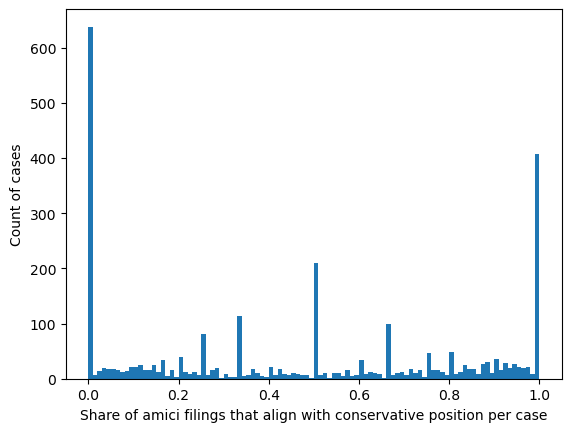

In [553]:
plt.hist(df_filt["percent_conservative"], bins=100)
plt.ylabel("Count of cases")
plt.xlabel("Share of amici filings that align with conservative position per case");

In [554]:
df_filt[df_filt['percent_conservative']==1]

,case_name,justices,case_decision,decisiondirection,amici,conservative_amici,percent_conservative,distinct_amicus_positions,num_amici
1954 U.S. LEXIS 2094,BROWN et al. v. BOARD OF EDUCATION OF TOPEKA e...,"[(HLBlack, 1.0, 2.0), (WODouglas, 1.0, 2.0), (...",1.0,2.0,"[(AMERICAN FEDERATION OF TEACHERS, 1), (UNITED...","[True, True, True, True, True, True, True, Tru...",1.0,1,11
1954 U.S. LEXIS 2095,BOLLING et al. v. SHARPE et al.,"[(HLBlack, 1.0, 2.0), (WODouglas, 1.0, 2.0), (...",1.0,2.0,"[(AMERICAN FEDERATION OF TEACHERS, 1), (UNITED...","[True, True, True, True, True, True, True, Tru...",1.0,1,21
1955 U.S. LEXIS 1383,"BISSO, RECEIVER, v. INLAND WATERWAYS CORPORATION","[(JHarlan2, nan, nan), (HLBlack, 1.0, 2.0), (W...",3.0,2.0,"[(COYLE LINES, INC., 2), (JOHN L. HAY COMPANY,...","[True, True, True, True, True]",1.0,1,5
1955 U.S. LEXIS 1480,WHITEHOUSE et al. v. ILLINOIS CENTRAL RAILROAD...,"[(JHarlan2, nan, nan), (HLBlack, 1.0, 1.0), (W...",3.0,1.0,"[(AFL-CIO RAILWAY EMPLOYEES DEPARTMENT, 1), (B...","[True, True, True, True, True, True, True, Tru...",1.0,1,14
1956 U.S. LEXIS 1708,"UNITED AUTOMOBILE, AIRCRAFT & AGRICULTURAL IMP...","[(JHarlan2, 1.0, 1.0), (HLBlack, 2.0, 2.0), (W...",2.0,1.0,"[(GEORGIA, 2), (UTAH, 2), (TEXAS, 2)]","[True, True, True]",1.0,1,3
...,...,...,...,...,...,...,...,...,...
2012 U.S. LEXIS 906,"MARCUS D. MIMS, PETITIONER v. ARROW FINANCIAL ...","[(JGRoberts, 1.0, 2.0), (AScalia, 1.0, 2.0), (...",4.0,2.0,[(NATIONAL FEDERATION OF INDEPENDENT BUSINESS ...,"[True, True]",1.0,1,2
2013 U.S. LEXIS 2543,"KIM MILLBROOK, PETITIONER v. UNITED STATES","[(JGRoberts, 1.0, 1.0), (AScalia, 1.0, 1.0), (...",4.0,1.0,"[(EDUCATION FUND, 1), (JUST DETENTION INTERNAT...","[True, True, True, True, True, True, True, True]",1.0,1,8
2013 U.S. LEXIS 4546,"EDWARD F. MARACICH, et al., PETITIONERS v. MIC...","[(JGRoberts, 1.0, 1.0), (AScalia, 2.0, 2.0), (...",5.0,1.0,"[(ELECTRONIC FRONTIER FOUNDATION, 1), (ELECTRO...","[True, True]",1.0,1,2
2013 U.S. LEXIS 915,"KATHLEEN SEBELIUS, SECRETARY OF HEALTH AND HUM...","[(JGRoberts, 1.0, 2.0), (AScalia, 1.0, 2.0), (...",4.0,2.0,"[(AMERICAN HOSPITAL ASSOCIATION, 2), (QUALITY ...","[True, True, True]",1.0,1,3


In [555]:
# look at first one
# BROWN et al. v. BOARD OF EDUCATION OF TOPEKA
# all amici values are 1
df_filt.loc[df_filt.index == '1954 U.S. LEXIS 2094', 'amici'].values

array([list([('AMERICAN FEDERATION OF TEACHERS', 1), ('UNITED STATES', 1), ('AMERICAN JEWISH CONGRESS', 1), ('AMERICAN VETERANS COMMITTEE', 1), ('AMERICAN ETHICAL UNION', 1), ('AMERICAN JEWISH COMMITTEE', 1), ('ANTI-DEFAMATION LEAGUE', 1), ('JAPANESE AMERICAN CITIZENS LEAGUE', 1), ('UNITARIAN FELLOWSHIP FOR SOCIAL JUSTICE', 1), ('AMERICAN CIVIL LIBERTIES UNION', 1), ('CONGRESS OF INDUSTRIAL ORGANIZATIONS', 1)])],
      dtype=object)

In [556]:
df_filt[df_filt['percent_conservative']==0]

,case_name,justices,case_decision,decisiondirection,amici,conservative_amici,percent_conservative,distinct_amicus_positions,num_amici
1954 U.S. LEXIS 2505,"SUPERIOR FILMS, INC. v. DEPARTMENT OF EDUCATIO...","[(HLBlack, 4.0, 2.0), (WODouglas, 4.0, 2.0), (...",3.0,2.0,"[(NATIONAL COUNCIL ON FREEDOM FROM CENSORSHIP,...","[False, False, False]",0.0,1,3
1954 U.S. LEXIS 2636,"DELTA AIR LINES, INC. v. SUMMERFIELD, POSTMAST...","[(HLBlack, 1.0, 1.0), (WODouglas, 1.0, 1.0), (...",2.0,1.0,"[(NORTHWEST AIRLINES, INC., 1), (TRANS-WORLD A...","[False, False, False]",0.0,1,3
1955 U.S. LEXIS 1388,PETERS v. HOBBY et al.,"[(JHarlan2, 1.0, 2.0), (HLBlack, 3.0, 2.0), (W...",4.0,2.0,"[(ENGINEERS AND SCIENTISTS OF AMERICA, 1), (AM...","[False, False, False]",0.0,1,3
1955 U.S. LEXIS 1399,FEDERAL POWER COMMISSION v. OREGON et al.,"[(JHarlan2, nan, nan), (HLBlack, 1.0, 1.0), (W...",3.0,1.0,"[(INDIANA, 2), (IZAAK WALTON LEAGUE OF AMERICA...","[False, False, False, False, False, False]",0.0,1,6
1955 U.S. LEXIS 1455,"WEBER et al. v. ANHEUSER-BUSCH, INC.","[(JHarlan2, nan, nan), (HLBlack, 4.0, 2.0), (W...",4.0,2.0,"[(NATIONAL LABOR RELATIONS BOARD, 1), (CONGRES...","[False, False]",0.0,1,2
...,...,...,...,...,...,...,...,...,...
2014 U.S. LEXIS 1787,ROSEMOND v. UNITED STATES,"[(JGRoberts, 1.0, 2.0), (AScalia, 1.0, 2.0), (...",5.0,2.0,[(NATIONAL ASSOCIATION OF CRIMINAL DEFENSE LAW...,"[False, False, False, False, False, False]",0.0,1,6
2014 U.S. LEXIS 2936,PAROLINE v. UNITED STATES,"[(JGRoberts, 2.0, 2.0), (AScalia, 2.0, 2.0), (...",5.0,1.0,"[(MOTHERS AGAINST DRUNK DRIVING, 2), (ARIZONA ...","[False, False, False, False, False, False, Fal...",0.0,1,56
2014 U.S. LEXIS 3991,SCIALABBA v. CUELLAR DE OSORIO,"[(JGRoberts, 4.0, 1.0), (AScalia, 4.0, 1.0), (...",4.0,1.0,"[(CATHOLIC LEGAL IMMIGRATION NETWORK, 2), (AME...","[False, False, False, False, False, False]",0.0,1,6
2014 U.S. LEXIS 4169,SUSAN B. ANTHONY LIST v. DRIEHAUS,"[(JGRoberts, 1.0, 2.0), (AScalia, 1.0, 2.0), (...",4.0,2.0,"[(AMERICAN BOOKSELLERS ASSOCIATION, 1), (AMERI...","[False, False, False, False, False, False, Fal...",0.0,1,64


## Apply Threshold Algorithm

In [567]:
final_justices

{'AFortas',
 'AJGoldberg',
 'AMKennedy',
 'AScalia',
 'BRWhite',
 'CEWhittaker',
 'CThomas',
 'DHSouter',
 'EKagan',
 'EWarren',
 'FFrankfurter',
 'HABlackmun',
 'HHBurton',
 'HLBlack',
 'JGRoberts',
 'JHarlan2',
 'JPStevens',
 'LFPowell',
 'PStewart',
 'RBGinsburg',
 'RHJackson',
 'SAAlito',
 'SDOConnor',
 'SFReed',
 'SGBreyer',
 'SMinton',
 'SSotomayor',
 'TCClark',
 'TMarshall',
 'WEBurger',
 'WHRehnquist',
 'WJBrennan',
 'WODouglas'}

In [623]:
selected_judge = 'EKagan'

In [624]:
# select data with which the judge has been a decision-maker
sel_cases_justice = justices_csv.loc[justices_csv['justiceName']==selected_judge]
assert sel_cases_justice['lexisCite'].unique().shape[0] == sel_cases_justice.shape[0]

df_selected = pd.merge(df_filt.reset_index(drop=False)\
         .rename({'index':'lexisCite'}, axis=1)[\
             ['lexisCite','conservative_amici', 'amici', 'percent_conservative', 'distinct_amicus_positions','num_amici']], \
                sel_cases_justice[['lexisCite', 'vote', 'direction', 'decisionDirection']], on='lexisCite', how='inner')

# check for uniqueness
assert df_selected['lexisCite'].unique().shape[0] == df_selected.shape[0]
df_selected['conservative_vote'] = np.select([df_selected['direction'] == 1, 
                                              df_selected['direction'] == 2,
                                              df_selected['direction'] == 3], [1,0,np.nan])
df_selected.head()

,lexisCite,conservative_amici,amici,percent_conservative,distinct_amicus_positions,num_amici,vote,direction,decisionDirection,conservative_vote
0,2010 U.S. LEXIS 9008,"[False, False, False]",[(NATIONAL ASSOCIATION OF CRIMINAL DEFENSE LAW...,0.000000,1,3,NaN,NaN,1.0,0.0
1,2011 U.S. LEXIS 1084,"[False, False, False, False, False, False, Fal...","[(MULTISTATE TAX COMMISSION, 2), (ALABAMA ASSO...",0.108108,2,37,1.0,1.0,1.0,1.0
2,2011 U.S. LEXIS 1085,"[False, False, False, False, False, False, Fal...","[(CHAMBER OF COMMERCE OF THE U.S., 2), (AMERIC...",0.517241,2,58,NaN,NaN,2.0,0.0
3,2011 U.S. LEXIS 1711,"[False, False, False, False, False, False, Fal...","[(JUVENILE PRODUCTS MANUFACTURERS ASSOCIATION,...",0.725000,2,40,NaN,NaN,1.0,0.0
4,2011 U.S. LEXIS 1712,"[False, False, False, False, False, True]","[(HABEAS CORPUS RESOURCE CENTER, 2), (FEDERAL ...",0.166667,2,6,1.0,1.0,1.0,1.0


In [625]:
df_selected['percent_conservative'].isna().sum()

0

In [626]:
import random
judge_threshold_min = [0]
judge_threshold_max = [1]
observed_thresholds = []
eps = 0.05
row = 0

while (abs(min(judge_threshold_max) - max(judge_threshold_min)) > eps) and \
  (row < df_selected.shape[0]):
  case_selection = df_selected.iloc[row,:]
  observed_threshold = case_selection['percent_conservative']
  judge_vote = case_selection['conservative_vote']
  observed_thresholds += [observed_threshold]
  if judge_vote == 0:
    judge_threshold_min += [max(observed_threshold, max(judge_threshold_min))]
    judge_threshold_max += [min(judge_threshold_max)]
  else:
    judge_threshold_min += [max(judge_threshold_min)]
    judge_threshold_max += [min(observed_threshold, max(judge_threshold_max))]
  row += 1

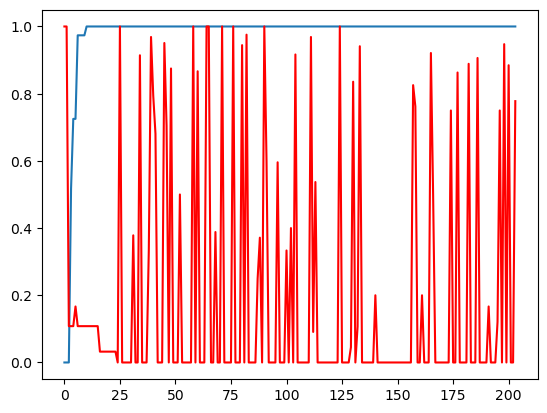

In [627]:
plt.plot(judge_threshold_min)
plt.plot(judge_threshold_max, color='red')
plt.show();

## Learning Weights